This is a Lorenz system parameter estimation prroblem solved with a PINN model using the DeepXDE library.

<br>
\begin{equation}
\frac{\partial x}{\partial t} = σ(y-x) \hspace{1cm} \frac{\partial y}{\partial t} = x(ρ-z)-y  \hspace{1cm} \frac{\partial z}{\partial t} = xy-βz \hspace{1cm} t∈[0,3]
\end{equation}
<br>
\begin{equation}
x(0)=-8 \hspace{1cm} y(0)=7 \hspace{1cm} z(0)=27
\end{equation}
<br>

The reference solution is here:
https://github.com/lululxvi/deepxde/blob/master/examples/dataset/Lorenz.npz
, where the parameters σ, ρ, and β are to be identified from observations of the system at certain times and whose true values are 10, 15, and 8/3, respectivly.

It utilizes resampling, L-BFGS optimization algorithm and residual-based adaptive refinement to improve the accuracy of the model.

Total test loss after 25273 epochs is approximately: **1.12e-04**

In [ ]:
# Import libraries

!pip install deepxde
import deepxde as dde
import numpy as np

     |████████████████████████████████| 122 kB 10.5 MB/s 
     |████████████████████████████████| 100 kB 8.6 MB/s 


Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



In [ ]:
# Define computational geometry

geom = dde.geometry.Interval(0,3)

In [ ]:
# Define unknown variables

c1 = dde.Variable(1.0)
c2 = dde.Variable(1.0)
c3 = dde.Variable(1.0)

In [ ]:
# Define ode system

def ode_system(x,y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    y3 = y[:, 2:3]
    dy1_x = dde.grad.jacobian(y, x, i = 0)
    dy2_x = dde.grad.jacobian(y, x, i = 1)
    dy3_x = dde.grad.jacobian(y, x, i = 2)
    return [ 
          dy1_x - c1 * (y2 - y1),
          dy2_x - y1 * (c2 - y3) + y2,
          dy3_x - y1 * y2 - c3 * y3]

In [ ]:
# Define initial conditions

def boundary(x,_):
    return np.isclose(x[0], 0)

ic1 = dde.icbc.DirichletBC(geom, lambda x: -8, boundary, component = 0)
ic2 = dde.icbc.DirichletBC(geom, lambda x: 7, boundary, component = 1)
ic3 = dde.icbc.DirichletBC(geom, lambda x: 27, boundary, component = 2)

In [ ]:
# Import and set the train data

def get_traindata():
    data = np.load("Lorenz.npz")
    return data["t"], data["y"]

inputs_t, outputs_y = get_traindata()
outputs_y0 = dde.icbc.PointSetBC(inputs_t, outputs_y[:, 0:1], component=0)
outputs_y1 = dde.icbc.PointSetBC(inputs_t, outputs_y[:, 1:2], component=1)
outputs_y2 = dde.icbc.PointSetBC(inputs_t, outputs_y[:, 2:3], component=2)

In [ ]:
# Accumulate all the data for the model

data = dde.data.PDE(geom, ode_system, [ic1, ic2, ic3, outputs_y0, outputs_y1, outputs_y2], num_domain = 1000, num_boundary = 4,
                    anchors = inputs_t, num_test = 100)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1002=1002. 
  total_n_samples))


In [ ]:
# Create the neural network

layer_size = [1] + [100] * 4 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

In [ ]:
# Build and train the model

model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[c1, c2, c3])

variable = dde.callbacks.VariableValue([c1, c2, c3], period=600, filename="variables.dat")
resampler = dde.callbacks.PDEResidualResampler(period=200)

losshistory, train_state = model.train(epochs=20000, callbacks=[variable, resampler])

/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Compiling model...
Building feed-forward neural network...
'build' took 0.097464 s

'compile' took 1.095680 s

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [9.13e-01, 7.03e-01, 9.28e-03, 6.40e+01, 4.90e+01, 7.29e+02, 3.80e+01, 3.62e+01, 2.54e+02]    [9.15e-01, 7.06e-01, 9.21e-03, 6.40e+01, 4.90e+01, 7.29e+02, 3.80e+01, 3.62e+01, 2.54e+02]    []  


/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1002=1002. 
  total_n_samples))


1000      [1.02e+01, 3.13e+00, 3.69e+00, 1.09e+01, 4.58e-01, 4.04e+00, 3.70e+01, 2.57e+01, 1.49e+00]    [9.75e+00, 3.09e+00, 3.61e+00, 1.09e+01, 4.58e-01, 4.04e+00, 3.70e+01, 2.57e+01, 1.49e+00]    []  
2000      [8.53e+00, 1.83e+00, 1.32e+00, 1.42e+01, 4.23e-01, 1.98e+00, 3.36e+01, 1.92e+01, 2.32e+00]    [7.99e+00, 1.80e+00, 1.23e+00, 1.42e+01, 4.23e-01, 1.98e+00, 3.36e+01, 1.92e+01, 2.32e+00]    []  
3000      [8.61e+00, 1.88e+00, 9.25e-01, 1.35e+01, 4.04e-01, 1.51e+00, 3.29e+01, 1.87e+01, 2.87e+00]    [8.10e+00, 1.86e+00, 8.72e-01, 1.35e+01, 4.04e-01, 1.51e+00, 3.29e+01, 1.87e+01, 2.87e+00]    []  
4000      [8.61e+00, 1.98e+00, 8.64e-01, 1.24e+01, 3.87e-01, 1.46e+00, 3.27e+01, 1.90e+01, 2.67e+00]    [8.11e+00, 1.97e+00, 7.83e-01, 1.24e+01, 3.87e-01, 1.46e+00, 3.27e+01, 1.90e+01, 2.67e+00]    []  
5000      [8.55e+00, 2.04e+00, 8.36e-01, 1.09e+01, 3.34e-01, 1.39e+00, 3.25e+01, 1.94e+01, 2.27e+00]    [8.16e+00, 2.07e+00, 7.44e-01, 1.09e+01, 3.34e-01, 1.39e+00, 3.25e+01, 1.94e+01, 2.2

In [ ]:
# Train the model with residual-based adaptive refinement

model.compile("L-BFGS")
model.train()

X = geom.random_points(100000)
err = 1

while err > 0.05:
    f = model.predict(X, operator=ode_system)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq, axis=1)
    p1 = X[x_id[0][0]]
    p2 = X[x_id[1][0]]
    p3 = X[x_id[2][0]]
    print("Adding new points:", p1, p2, p3, "\n")
    data.add_anchors(np.array([p1, p2, p3]))
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(epochs=10000, disregard_previous_best=True, callbacks=[early_stopping])
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

Compiling model...
'compile' took 0.487955 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
20000     [1.52e-02, 2.46e-02, 1.73e-02, 3.66e-03, 1.12e-04, 2.11e-03, 2.12e-02, 1.71e-02, 2.18e-02]    [1.40e-02, 2.14e-02, 1.65e-02, 3.66e-03, 1.12e-04, 2.11e-03, 2.12e-02, 1.71e-02, 2.18e-02]    []  
21000     [1.20e-04, 1.69e-04, 2.66e-04, 7.39e-10, 4.33e-07, 8.04e-09, 7.06e-06, 6.08e-06, 6.93e-06]                                                                                                      
22000     [3.25e-05, 2.25e-05, 7.88e-05, 7.26e-08, 2.59e-07, 1.49e-08, 6.55e-06, 4.88e-06, 5.03e-06]                                                                                                      
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Object

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


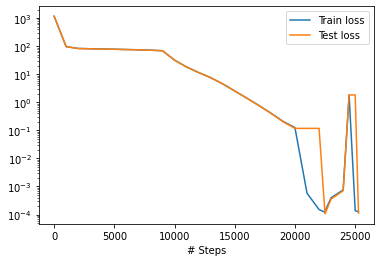

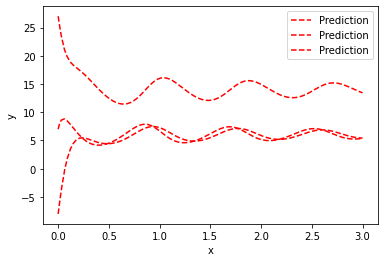

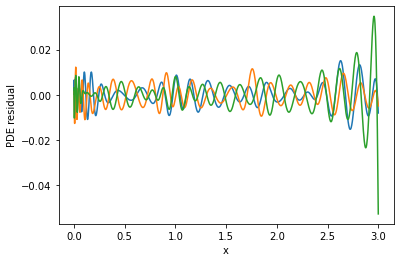

In [ ]:
# Generating plots of the results.

import matplotlib.pyplot as plt

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=ode_system)

plt.figure()
plt.plot(x, y[0])
plt.plot(x, y[1])
plt.plot(x, y[2])
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()